All States Superset binning

# Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"]="2"
import warnings; warnings.simplefilter('ignore')

In [ ]:
!ls '/content/drive/Shared drives/CMPE 295- Master Project/projectdata-2021'

 All_CovidDataFeb20.csv
 alldatasets_Feb20.csv
 All_GoogleMobilityDataFeb20.csv
 All_SocialDistancingDataFeb20.csv
 AllStates_Superset_dataset_Feb20.csv
 AllStates_Superset_dataset_Feb21.csv
 CA_alldatasets_Feb05.csv
 CA_alldatasets_Jan13.csv
 CA_CombinedData_Labeled_CDCGuideline_Feb05.csv
 CA_CombinedData_Labeled_CDCGuideline_Feb06.csv
 CA_CombinedData_Labeled_CDCGuideline_Jan15.csv
 CA_combined_Feb04.csv
 CA_CovidDataJan10.csv
 CA_dataset_Feb11.csv
 CA_GoogleMobilityDataJan10.csv
 CA_MarylandData_Labeled_CDCGuideline_Feb05.csv
 CA_MarylandData_Labeled_CDCGuideline_Feb06.csv
 CA_MarylandData_Labeled_CDCGuideline_Jan15.csv
 CA_processedMarylandData_Feb04.csv
 CA_processedMarylandData_Feb05.csv
 CA_processedMarylandData_Feb12.csv
 CA_processedMarylandData_Jan11.csv
 CA_SocialDistancingDataJan10.csv
 CA_socialDistancingInertiaData_Feb04.csv
 CA_SuperData_Labeled_CDCGuideline_Feb13.csv
 CA_SuperData_Labeled_Guideline_Feb26.csv
 CA_Superset_bins_dataset_Feb20.csv
 CA_Superset_dataset_Feb12

In [3]:
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler as ss
import itertools
from scipy import linalg
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
import numpy as np
import matplotlib.pyplot as plt

# Load Dataset

In [4]:
all_superset_data = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/projectdata-2021/AllStates_Superset_dataset_Mar26.csv',low_memory=False)

## Filter for OR

In [5]:
all_superset_data.head(2)

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k
0,2020-03-01,Alabama,1001,0,Autauga County,0.0,7.194,49,15.0,13.0,0.0,0.0,3.0,0.0,35.853419,Alabama,35,22,2.81,41.6,1.0,32.9,0.26,2.55,0,55601,-1.2,0.11,19,58786,19.0,2.8,48.68,19,101,3.79,0.33,0.025,0.0,0.0,37,47.1,0.0,0.0,0.0,0,0,0.0,28,0.4,3.5,3.2,0.3,0.0,0.0,0.0
1,2020-03-02,Alabama,1001,0,Autauga County,0.0,14.587,100,15.0,4.0,0.0,0.0,5.0,-1.0,35.853419,Alabama,11,13,3.33,40.9,0.5,42.0,0.80,2.53,0,55601,-1.9,0.11,19,58786,19.0,2.8,48.68,19,101,3.79,0.33,0.025,0.0,0.0,38,47.1,0.0,0.0,0.0,0,0,0.0,28,0.4,3.5,3.2,0.3,0.0,0.0,0.0


In [6]:
OR_superset_data = all_superset_data[all_superset_data['Province_State'] == 'Oregon']

In [7]:
OR_superset_data['County Name'].nunique()

29

In [8]:
OR_superset_data.head()

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k
43498,2020-03-01,Oregon,41029,0,Jackson County,0.0,2.899,56,17.0,10.0,71.0,-24.0,4.0,-2.0,29.723811,Oregon,32,25,3.37,10.7,3.2,37.6,0.29,3.08,0,219564,-4.2,1.11,29,50851,0.6,12.5,48.75,32,158,2.2,0.2,0.024,0.0,0.0,37,48.8,0.0,0.00,0.0,0,0,0.04,0,1.0,3.3,6.8,0.6,0.0,0.0,42.944750
43499,2020-03-02,Oregon,41029,0,Jackson County,0.0,4.856,94,9.0,5.0,36.0,-17.0,3.0,-1.0,29.723811,Oregon,14,19,3.96,9.7,2.4,39.1,0.69,3.28,0,219564,2.0,1.11,29,50851,0.6,12.5,48.75,32,158,2.2,0.2,0.024,0.0,0.0,38,48.8,0.0,0.00,0.0,0,0,0.07,0,1.0,3.3,6.8,0.6,0.0,0.0,28.629833
43500,2020-03-03,Oregon,41029,0,Jackson County,0.0,5.086,98,11.0,10.0,53.0,-15.0,2.0,-1.0,29.723811,Oregon,13,17,4.12,9.7,2.4,39.5,0.75,3.38,0,219564,5.1,1.11,29,50851,0.6,12.5,48.75,32,158,2.2,0.2,0.024,0.0,0.0,39,48.8,0.0,0.00,0.0,0,0,0.06,0,1.0,3.3,6.8,0.6,0.0,0.0,20.613480
43501,2020-03-04,Oregon,41029,0,Jackson County,0.0,5.158,100,10.0,8.0,62.0,-1.0,1.0,-1.0,29.723811,Oregon,14,18,4.08,9.7,2.4,38.9,0.72,3.36,0,219564,4.5,1.11,29,50851,0.6,12.5,48.75,32,158,2.2,0.2,0.024,0.0,0.0,40,48.8,9.4,0.01,0.0,0,0,0.05,0,1.0,3.3,6.8,0.6,0.0,0.0,20.613480
43502,2020-03-05,Oregon,41029,0,Jackson County,0.0,5.652,109,11.0,9.0,45.0,6.0,1.0,-1.0,29.723811,Oregon,14,18,4.10,9.9,2.5,39.1,0.72,3.38,0,219564,5.1,1.11,29,50851,0.6,12.5,48.75,32,158,2.2,0.2,0.024,0.0,0.0,41,48.8,6.2,0.01,0.0,0,0,0.03,0,1.0,3.3,6.8,0.6,0.0,0.0,8.588950


In [9]:
OR_superset_data.columns

Index(['Date', 'Province_State', 'FIPS', 'New cases', 'County Name',
       'mask_rule_severity', 'm50', 'm50_index',
       'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline', 'PopDensity', 'State_Name',
       'Social.distancing.index', 'X..staying.home', 'Trips.person',
       'X..out.of.county.trips', 'X..out.of.state.trips', 'Miles.person',
       'Work.trips.person', 'Non.work.trips.person', 'New.COVID.cases',
       'Population', 'X..change.in.consumption', 'Transit.mode.share',
       'X..people.older.than.60', 'Median.income', 'X..African.Americans',
       'X..Hispanic.Americans', 'X..Male', 'Employment.density',
       'X..hot.spots.1000.people', 'Hospital.beds.1000.people',
       'ICUs.1000.people', 'X..contact.tr

In [10]:
OR_superset_data.shape

(8234, 56)

# Binning


In [11]:
copy_OR_superset_data = OR_superset_data

In [12]:
or_superset_data_agg = pd.DataFrame(columns=OR_superset_data.columns)

In [13]:
for county in copy_OR_superset_data['County Name'].unique():
  county_copy_OR_superset_data = copy_OR_superset_data[copy_OR_superset_data['County Name'] == county]
  county_copy_OR_superset_data = county_copy_OR_superset_data.sort_values(by='Date')
  county_copy_OR_superset_data['Date'] = county_copy_OR_superset_data['Date'].astype('datetime64[ns]')
  semi_monthly_data = county_copy_OR_superset_data.groupby("County Name").resample('SM', on='Date').mean().reset_index()
  semi_monthly_data['Province_State'] = "Oregon"
  semi_monthly_data['State_Name'] = "Oregon"
  semi_monthly_data["State"] = "OR"
  semi_monthly_data["CTNAME"] = county
  or_superset_data_agg = or_superset_data_agg.append(semi_monthly_data)


In [14]:
or_superset_data_agg.head(5)

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k,State,CTNAME
0,2020-02-29,Oregon,41029.0,0.142857,Jackson County,0.0,4.668500,90.071429,6.857143,7.714286,43.214286,-13.357143,0.857143,-0.357143,29.723811,Oregon,20.357143,20.428571,3.827143,10.035714,2.635714,36.807143,0.591429,3.236429,0.142857,219564.0,0.642857,1.11,29.0,50851.0,0.6,12.5,48.75,32.0,158.0,2.2,0.2,0.024,0.000643,0.002143,17.000000,48.812683,5.992857,0.035714,0.025714,0.214286,0.000000,0.061429,0.000000,1.000000,3.300000,7.250000,0.600000,0.000000,0.065064,9.063012,OR,Jackson County
1,2020-03-15,Oregon,41029.0,1.125000,Jackson County,0.0,2.250875,43.125000,-31.625000,-4.500000,29.687500,-30.750000,-29.187500,9.375000,29.723811,Oregon,41.562500,29.000000,3.193750,9.775000,2.700000,27.906250,0.477500,2.715625,1.125000,219564.0,-15.550000,1.11,29.0,50851.0,0.6,12.5,48.75,32.0,158.0,2.2,0.2,0.024,0.003894,0.055000,3.375000,49.306294,5.418750,1.125000,1.244375,9.562500,1.937500,0.046250,3.062500,8.468750,6.643750,23.131250,0.600000,3.675000,0.512379,0.203325,OR,Jackson County
2,2020-03-31,Oregon,41029.0,1.800000,Jackson County,0.0,1.390867,26.466667,-38.800000,-11.333333,25.866667,-31.666667,-39.133333,12.466667,29.723811,Oregon,47.066667,30.400000,3.115333,9.020000,2.333333,24.760000,0.438000,2.679333,1.800000,219564.0,-16.680000,1.11,29.0,50851.0,0.6,12.5,48.75,32.0,158.0,2.2,0.2,0.024,0.009413,0.264000,2.466667,50.132514,5.160000,5.416667,5.640667,25.933333,9.866667,0.060667,18.200000,11.873333,13.086667,26.306667,0.226667,12.996000,0.819807,1.071387,OR,Jackson County
3,2020-04-15,Oregon,41029.0,0.142857,Jackson County,0.0,1.776214,33.857143,-30.428571,-8.000000,42.285714,-30.142857,-36.000000,10.142857,29.723811,Oregon,38.857143,26.785714,3.280714,10.100000,2.585714,27.792857,0.425714,2.855714,0.214286,219564.0,-11.192857,1.11,29.0,50851.0,0.6,12.5,48.75,32.0,158.0,2.2,0.2,0.024,0.000964,0.420714,9.142857,50.062779,4.814286,10.334286,8.497143,25.785714,19.571429,0.092857,33.500000,10.242857,14.614286,28.185714,0.200000,20.927857,0.065064,0.139423,OR,Jackson County
4,2020-04-30,Oregon,41029.0,0.066667,Jackson County,0.0,2.513800,48.266667,-24.533333,2.533333,40.733333,-22.933333,-32.133333,9.000000,29.723811,Oregon,30.866667,23.800000,3.440000,10.853333,2.920000,31.513333,0.406667,3.034000,0.066667,219564.0,-5.646667,1.11,29.0,50851.0,0.6,12.5,48.75,32.0,158.0,2.2,0.2,0.024,0.000300,0.422000,18.000000,49.811245,4.266667,16.700667,5.338000,20.600000,25.000000,0.154667,48.066667,7.473333,14.186667,29.866667,0.200000,18.751333,0.030363,0.021688,OR,Jackson County


In [15]:
or_superset_data_agg.shape

(580, 58)

In [16]:
or_superset_data_agg['County Name'].nunique()

29

In [17]:
or_superset_data_agg = or_superset_data_agg.dropna()

In [18]:
or_superset_data_agg['County Name'].nunique()

29

In [20]:
or_superset_data_agg.shape

(580, 58)

# Convert to CSV

In [22]:
from datetime import datetime
location = '/content/drive/Shared drives/CMPE 295- Master Project/projectdata-2021/'
filename = 'OR_Superset_bins_dataset_'+datetime.now().strftime("%b%d")+'.csv' #%Y%m%d
print(filename)
or_superset_data_agg.to_csv(location+filename,index=False)

OR_Superset_bins_dataset_Mar26.csv


In [23]:
or_superset_data_agg.head()

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k,State,CTNAME
0,2020-02-29,Oregon,41029.0,0.142857,Jackson County,0.0,4.668500,90.071429,6.857143,7.714286,43.214286,-13.357143,0.857143,-0.357143,29.723811,Oregon,20.357143,20.428571,3.827143,10.035714,2.635714,36.807143,0.591429,3.236429,0.142857,219564.0,0.642857,1.11,29.0,50851.0,0.6,12.5,48.75,32.0,158.0,2.2,0.2,0.024,0.000643,0.002143,17.000000,48.812683,5.992857,0.035714,0.025714,0.214286,0.000000,0.061429,0.000000,1.000000,3.300000,7.250000,0.600000,0.000000,0.065064,9.063012,OR,Jackson County
1,2020-03-15,Oregon,41029.0,1.125000,Jackson County,0.0,2.250875,43.125000,-31.625000,-4.500000,29.687500,-30.750000,-29.187500,9.375000,29.723811,Oregon,41.562500,29.000000,3.193750,9.775000,2.700000,27.906250,0.477500,2.715625,1.125000,219564.0,-15.550000,1.11,29.0,50851.0,0.6,12.5,48.75,32.0,158.0,2.2,0.2,0.024,0.003894,0.055000,3.375000,49.306294,5.418750,1.125000,1.244375,9.562500,1.937500,0.046250,3.062500,8.468750,6.643750,23.131250,0.600000,3.675000,0.512379,0.203325,OR,Jackson County
2,2020-03-31,Oregon,41029.0,1.800000,Jackson County,0.0,1.390867,26.466667,-38.800000,-11.333333,25.866667,-31.666667,-39.133333,12.466667,29.723811,Oregon,47.066667,30.400000,3.115333,9.020000,2.333333,24.760000,0.438000,2.679333,1.800000,219564.0,-16.680000,1.11,29.0,50851.0,0.6,12.5,48.75,32.0,158.0,2.2,0.2,0.024,0.009413,0.264000,2.466667,50.132514,5.160000,5.416667,5.640667,25.933333,9.866667,0.060667,18.200000,11.873333,13.086667,26.306667,0.226667,12.996000,0.819807,1.071387,OR,Jackson County
3,2020-04-15,Oregon,41029.0,0.142857,Jackson County,0.0,1.776214,33.857143,-30.428571,-8.000000,42.285714,-30.142857,-36.000000,10.142857,29.723811,Oregon,38.857143,26.785714,3.280714,10.100000,2.585714,27.792857,0.425714,2.855714,0.214286,219564.0,-11.192857,1.11,29.0,50851.0,0.6,12.5,48.75,32.0,158.0,2.2,0.2,0.024,0.000964,0.420714,9.142857,50.062779,4.814286,10.334286,8.497143,25.785714,19.571429,0.092857,33.500000,10.242857,14.614286,28.185714,0.200000,20.927857,0.065064,0.139423,OR,Jackson County
4,2020-04-30,Oregon,41029.0,0.066667,Jackson County,0.0,2.513800,48.266667,-24.533333,2.533333,40.733333,-22.933333,-32.133333,9.000000,29.723811,Oregon,30.866667,23.800000,3.440000,10.853333,2.920000,31.513333,0.406667,3.034000,0.066667,219564.0,-5.646667,1.11,29.0,50851.0,0.6,12.5,48.75,32.0,158.0,2.2,0.2,0.024,0.000300,0.422000,18.000000,49.811245,4.266667,16.700667,5.338000,20.600000,25.000000,0.154667,48.066667,7.473333,14.186667,29.866667,0.200000,18.751333,0.030363,0.021688,OR,Jackson County


# Verification

In [24]:
county_WA_superset_data = or_superset_data_agg[or_superset_data_agg['County Name']== 'Washington County']

In [33]:
start_date = "2020-10-01"
end_date = "2020-10-15"

In [31]:
county_WA_superset_data[county_WA_superset_data["Date"] == "2020-10-15"]

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k,State,CTNAME
15,2020-10-15,Oregon,41067.0,55.375,Washington County,0.0,3.189125,54.75,-19.625,-8.25,12.25,-48.625,-34.875,12.375,310.164459,Oregon,34.75,27.9375,3.399375,27.88125,2.45,33.375,0.345625,3.055,55.375,597695.0,2.68125,6.13,18.0,78010.0,1.9,16.5,49.42,354.0,132.0,2.2,0.2,0.024,0.0877,2.283125,1.3125,51.267599,5.075,193.5025,6.36875,18.3125,824.5625,6.616875,20.5625,1.01875,6.54375,32.45625,1.71,2.319375,9.264759,8.390866,OR,Washington County


In [34]:
OCT_OR_superset_data = OR_superset_data[(OR_superset_data['Date'] > start_date) & (OR_superset_data['Date'] <= end_date)]

In [35]:
OCT_OR_superset_data.shape

(377, 56)

In [36]:
OCT_OR_superset_data.head(15)

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k
43711,2020-10-02,Oregon,41029,12,Jackson County,0.0,5.466,105,-8.0,2.0,42.0,-17.0,-19.0,4.0,29.723811,Oregon,21,20,4.45,10.6,2.7,34.0,0.47,3.97,12,219564,23.5,1.11,29,50851,0.6,12.5,48.75,32,158,2.2,0.2,0.024,0.0881,1.68,0,50.996480,4.9,166.39,5.73,15,112,5.51,0,0.9,7.2,32.9,1.71,2.44,5.465377,6.896785
43712,2020-10-03,Oregon,41029,16,Jackson County,0.0,3.752,72,-9.0,5.0,81.0,-8.0,-3.0,-1.0,29.723811,Oregon,29,23,3.90,13.0,3.6,28.7,0.28,3.62,16,219564,12.6,1.11,29,50851,0.6,12.5,48.75,32,158,2.2,0.2,0.024,0.0835,1.70,0,51.006212,4.9,167.49,5.73,15,125,5.57,0,0.9,7.2,32.9,1.71,2.45,7.287169,6.896785
43713,2020-10-04,Oregon,41029,9,Jackson County,0.0,2.974,57,1.0,4.0,83.0,-11.0,-3.0,-1.0,29.723811,Oregon,35,26,3.56,12.6,3.1,28.7,0.20,3.36,9,219564,4.5,1.11,29,50851,0.6,12.5,48.75,32,158,2.2,0.2,0.024,0.0562,1.69,1,51.053732,4.9,168.33,5.73,15,103,5.63,0,1.0,6.9,32.6,1.71,2.42,4.099033,6.896785
43714,2020-10-05,Oregon,41029,13,Jackson County,0.0,4.044,78,-3.0,4.0,54.0,-14.0,-25.0,3.0,29.723811,Oregon,28,22,3.85,9.3,1.9,23.2,0.53,3.31,13,219564,2.9,1.11,29,50851,0.6,12.5,48.75,32,158,2.2,0.2,0.024,0.0577,1.70,0,51.085148,4.9,169.19,5.13,15,82,5.69,0,1.0,6.9,32.6,1.71,2.40,5.920825,6.896785
43715,2020-10-06,Oregon,41029,8,Jackson County,0.0,4.366,84,-7.0,4.0,61.0,-14.0,-24.0,4.0,29.723811,Oregon,21,21,3.89,11.4,3.0,33.6,0.53,3.35,8,219564,4.2,1.11,29,50851,0.6,12.5,48.75,32,158,2.2,0.2,0.024,0.0455,1.72,0,51.146851,5.0,170.23,6.56,16,107,5.74,7,1.0,6.9,32.6,1.71,2.41,3.643585,6.766657
43716,2020-10-07,Oregon,41029,20,Jackson County,0.0,4.189,81,-5.0,6.0,44.0,0.0,-23.0,4.0,29.723811,Oregon,32,21,4.29,10.6,2.7,35.6,0.50,3.79,20,219564,17.9,1.11,29,50851,0.6,12.5,48.75,32,158,2.2,0.2,0.024,0.0622,1.76,0,51.209994,5.0,171.47,4.65,15,115,5.79,7,1.0,6.9,32.6,1.71,2.40,9.108961,6.831721
43717,2020-10-09,Oregon,41029,24,Jackson County,0.0,4.659,90,-9.0,-1.0,39.0,-19.0,-21.0,5.0,29.723811,Oregon,31,21,3.56,14.1,3.9,41.9,0.48,3.08,24,219564,-4.2,1.11,29,50851,0.6,12.5,48.75,32,158,2.2,0.2,0.024,0.0911,1.90,2,51.338100,5.0,174.35,5.85,16,140,5.92,7,1.0,6.9,32.6,1.71,2.41,10.930754,6.636529
43718,2020-10-10,Oregon,41029,22,Jackson County,0.0,3.625,70,-11.0,4.0,29.0,-6.0,-3.0,1.0,29.723811,Oregon,49,25,3.24,13.2,3.5,27.3,0.28,2.96,22,219564,-8.0,1.11,29,50851,0.6,12.5,48.75,32,158,2.2,0.2,0.024,0.0941,1.96,0,51.398080,5.0,175.77,5.85,17,117,5.98,7,1.0,6.9,32.6,1.71,2.39,10.019858,7.287169
43719,2020-10-11,Oregon,41029,0,Jackson County,0.0,3.039,58,0.0,1.0,77.0,-14.0,-5.0,0.0,29.723811,Oregon,36,26,3.33,12.7,3.3,29.4,0.20,3.13,0,219564,-2.7,1.11,29,50851,0.6,12.5,48.75,32,158,2.2,0.2,0.024,0.0698,1.99,1,51.406607,5.0,176.88,5.85,17,126,6.03,7,1.1,6.7,32.5,1.71,2.37,0.000000,6.246145
43720,2020-10-12,Oregon,41029,15,Jackson County,0.0,3.9

In [ ]:
washington_OR_superset_data_agg = ca_superset_data_agg[(ca_superset_data_agg['Date'] == end_date) & (ca_superset_data_agg['County Name'] == "Washington County")]

In [ ]:
washington_OR_superset_data_agg.head()

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,State,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate
15,2020-10-15,Oregon,41067.0,55.375,Washington County,10.0,7.870638,81.901786,-19.625,-8.25,12.25,-48.625,-34.875,12.375,310.164459,Oregon,OR,41067.0,Washington County,41.0,34.75,27.9375,3.399375,27.88125,2.45,33.375,0.345625,3.055,55.375,597695.0,2.68125,6.13,18.0,78010.0,1.9,16.5,49.42,354.0,132.0,2.2,0.2,0.024,0.0877,2.283125,1.3125,51.267599,5.075,193.5025,6.36875,18.3125,824.5625,6.616875,20.5625,1.01875,6.54375,32.45625,1.71,2.319375


In [ ]:
washington_OR_superset_data_agg.T

,15
Date,2020-10-15 00:00:00
Province_State,Oregon
FIPS,41067
New cases,55.375
County Name,Washington County
mask_rule_severity,10
m50,7.87064
m50_index,81.9018
retail_and_recreation_percent_change_from_baseline,-19.625
grocery_and_pharmacy_percent_change_from_baseline,-8.25


# Visualtizations

In [ ]:
X_cols_feature_selected = ['Tests.done.1000.people',
 'X..staying.home','Unemployment.rate',
 'X..people.older.than.60','X..working.from.home','X.days..decreasing.ILI.cases',
 'X..Male','X..out.of.county.trips','parks_percent_change_from_baseline',
 'Work.trips.person','m50_index','FIPS','Imported.COVID.cases',
 'X..out.of.state.trips','Miles.person',
 'X.days..decreasing.COVID.cases','grocery_and_pharmacy_percent_change_from_baseline',
 'transit_stations_percent_change_from_baseline',
 'Testing.capacity','retail_and_recreation_percent_change_from_baseline','Unemployment.claims.1000.people',
 'Date', 'Social.distancing.index', 'New cases']

In [ ]:
temp = CA_superset_data[X_cols_feature_selected]

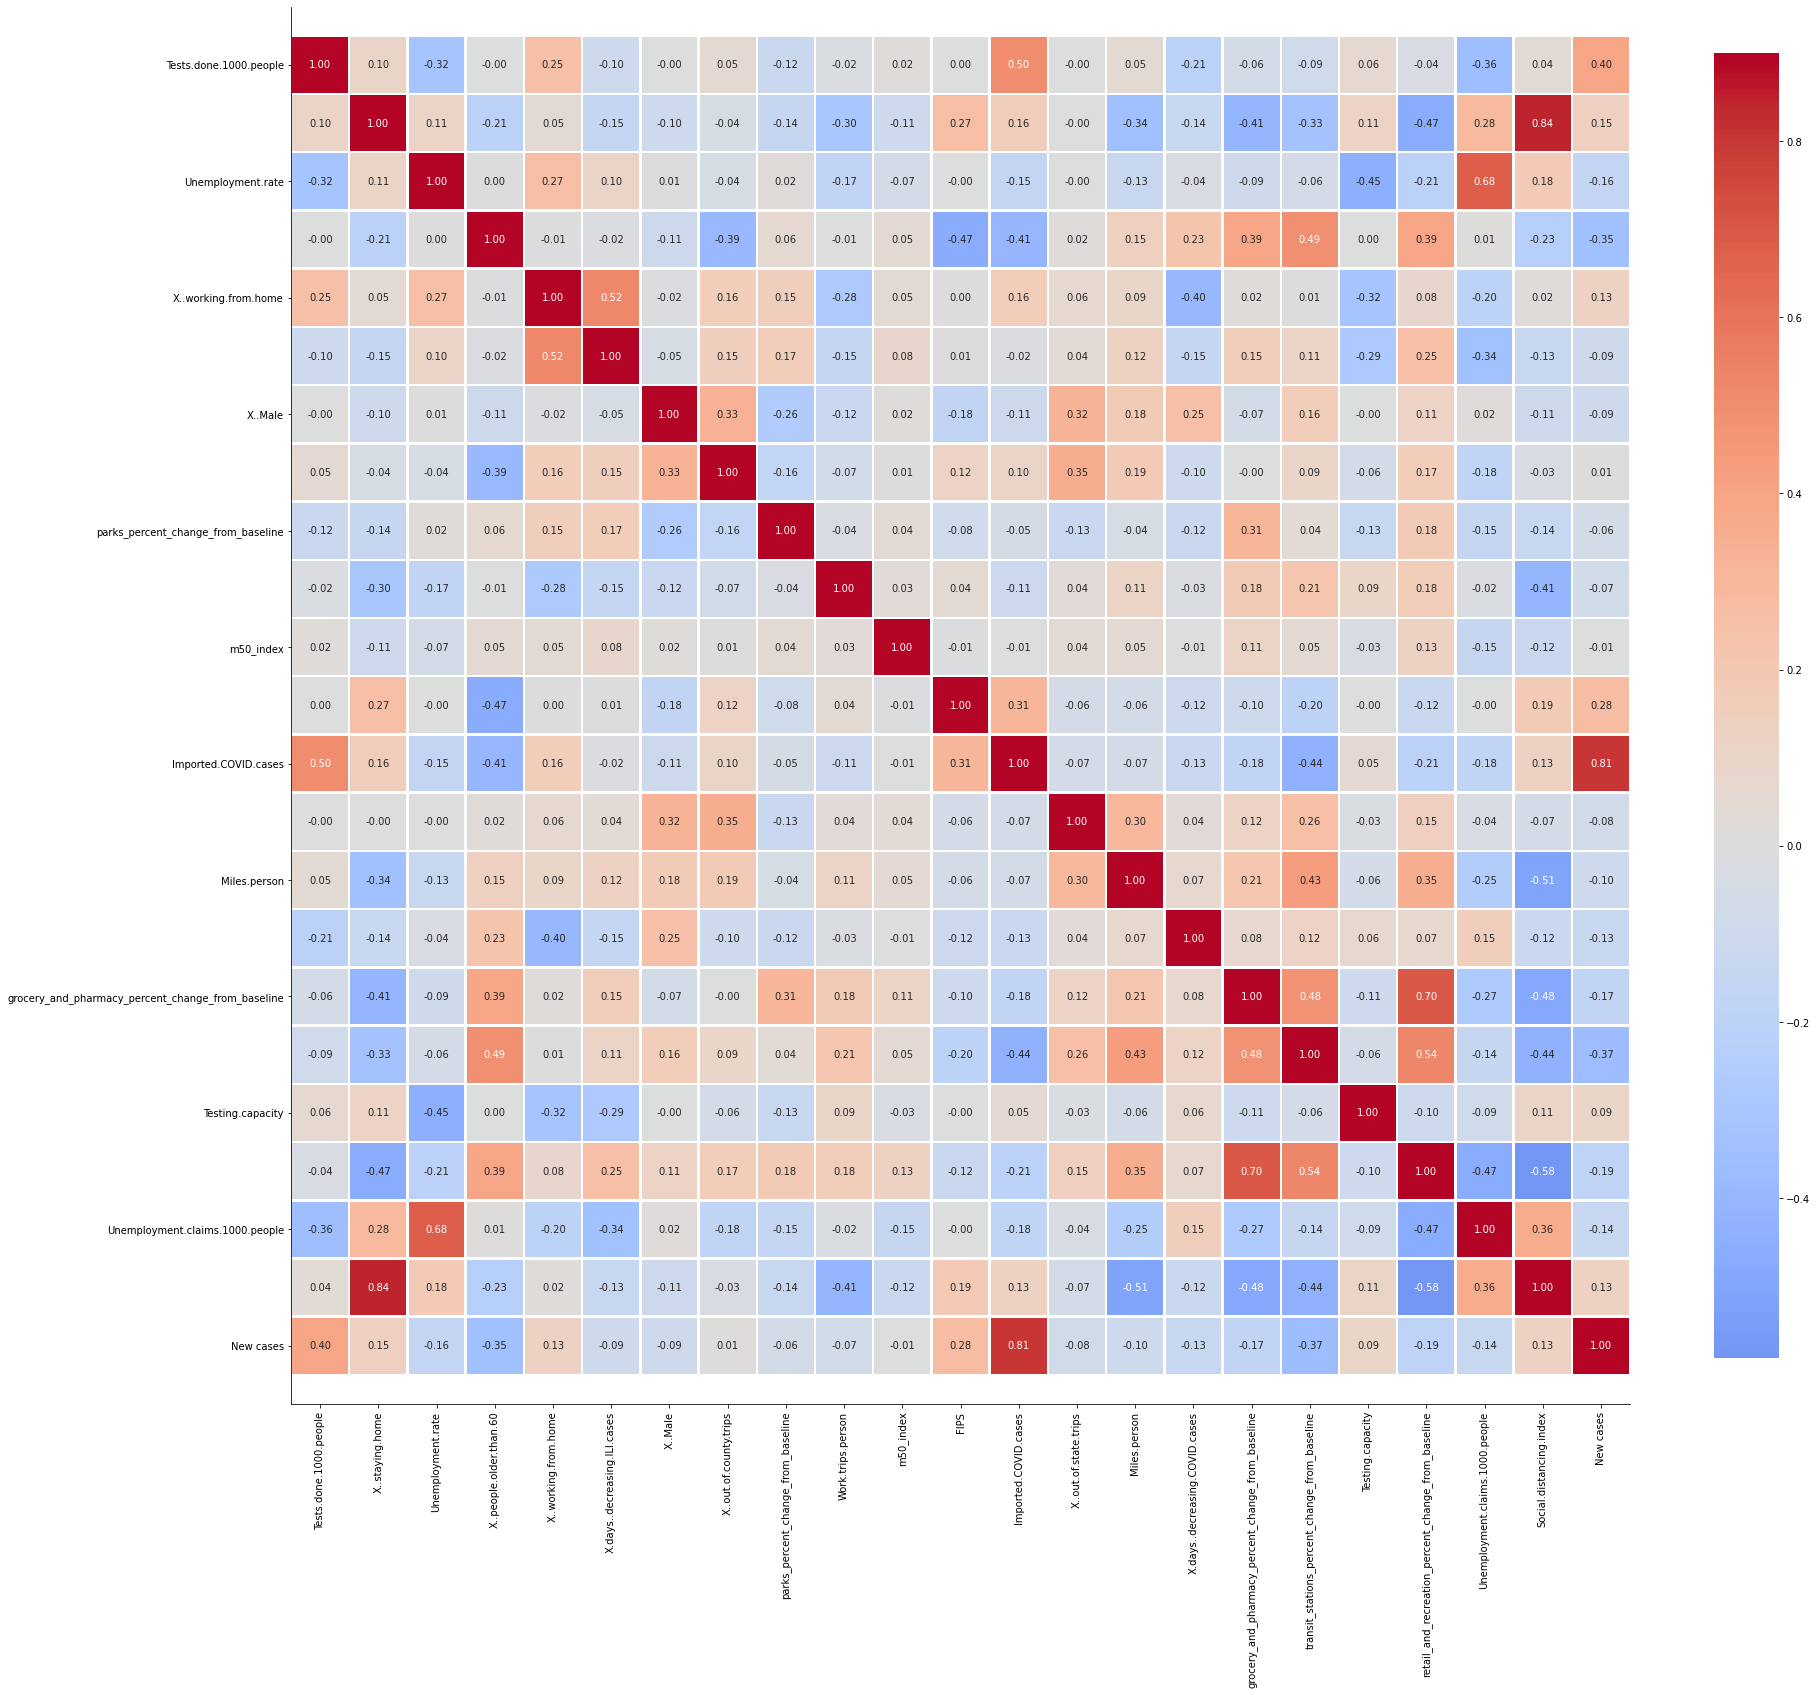

In [ ]:
corr = temp.corr()
g = sns.heatmap(corr, vmax=.9, center=0,
               square=True, linewidths=1.5, cbar_kws={"shrink": .8}, annot=True, fmt='.2f', cmap='coolwarm')
bottom, top = g.get_ylim()
g.set_ylim(bottom + 0.5, top - 0.5)
sns.despine()
g.figure.set_size_inches(30, 30)


In [ ]:
g.figure.savefig('foo.png')